# Get data  from Hive

In [147]:
# pip install sasl
# pip install thrift
# pip install thrift-sasl
# pip install PyHive

In [ ]:
from pyhive import hive
conn = hive.Connection(host="YOUR_HIVE_HOST", port=PORT, username="YOU")

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT cool_stuff FROM hive_table")
for result in cursor.fetchall():
  use_result(result)

In [ ]:
# ...or to use the connection to make a Pandas dataframe:

In [ ]:
import pandas as pd
df = pd.read_sql("SELECT cool_stuff FROM hive_table", conn)

# Credit Card Fraud Detection

Content <br>
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
# Import functions

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Load data

In [142]:
data = pd.read_csv('creditcard.csv')

# 1. Exploratory Data Analysis

In [138]:
#data.head()

In [137]:
# check data types
#data.info()

In [139]:
# check basic statistics
#data.describe()

Comment: V1-V28 are first scaled then PCA transformation is applied. Features 'Time' and 'Amount' have to be scaled.

In [6]:
# check data frame dimensions
data.shape

(284807, 31)

### Fraud - nonFraud distribution

0    284315
1       492
Name: Class, dtype: int64

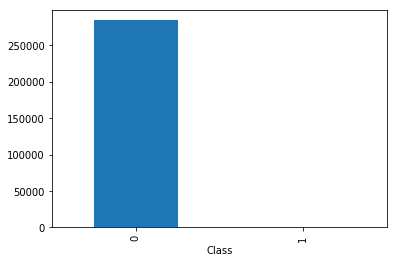

In [7]:
%matplotlib inline

data.groupby('Class').size().plot(kind='bar')

data.Class.value_counts()


Comment: 492 fraudulent and 284315 normal transactions.
Highly Unbalanced set !!!

### Check missing values, features distributions

In [8]:
# Check if there are missing values: no missing values
data.isnull().values.any()

False

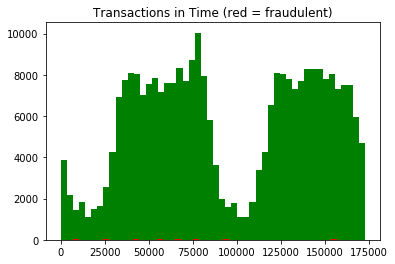

In [10]:
df_normal = data[data.Class==0]
df_fraud = data[data.Class==1]
colors = ["green","red"]
names = ["normal","red"]
plt.hist([df_normal['Time']],bins=50, color = "green");
plt.hist([df_fraud['Time']],bins=50, color = "red");
plt.title("Transactions in Time (red = fraudulent)")
plt.show()

## Density Plots

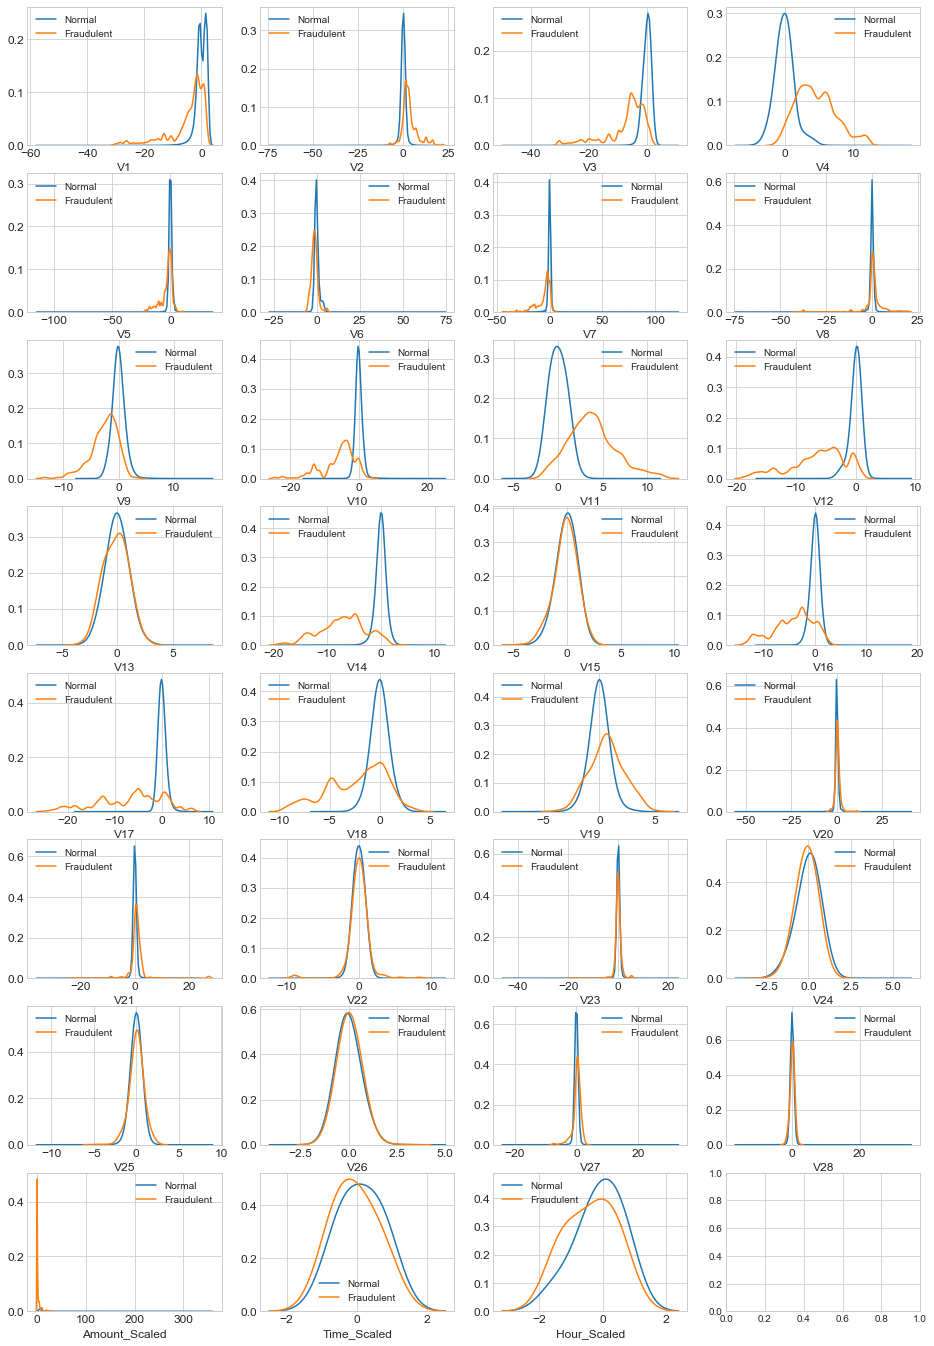

In [125]:
features = [f for f in data.columns if f not in ['Class']]

ii = 1
t0 = data[data['Class'] == 0]
t1 = data[data['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,24))

for feature in features:    
    plt.subplot(8,4,ii)
    sns.kdeplot(t0[feature], bw=0.5,label="Normal")
    sns.kdeplot(t1[feature], bw=0.5,label="Fraudulent")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    ii += 1
plt.show();

## Histograms

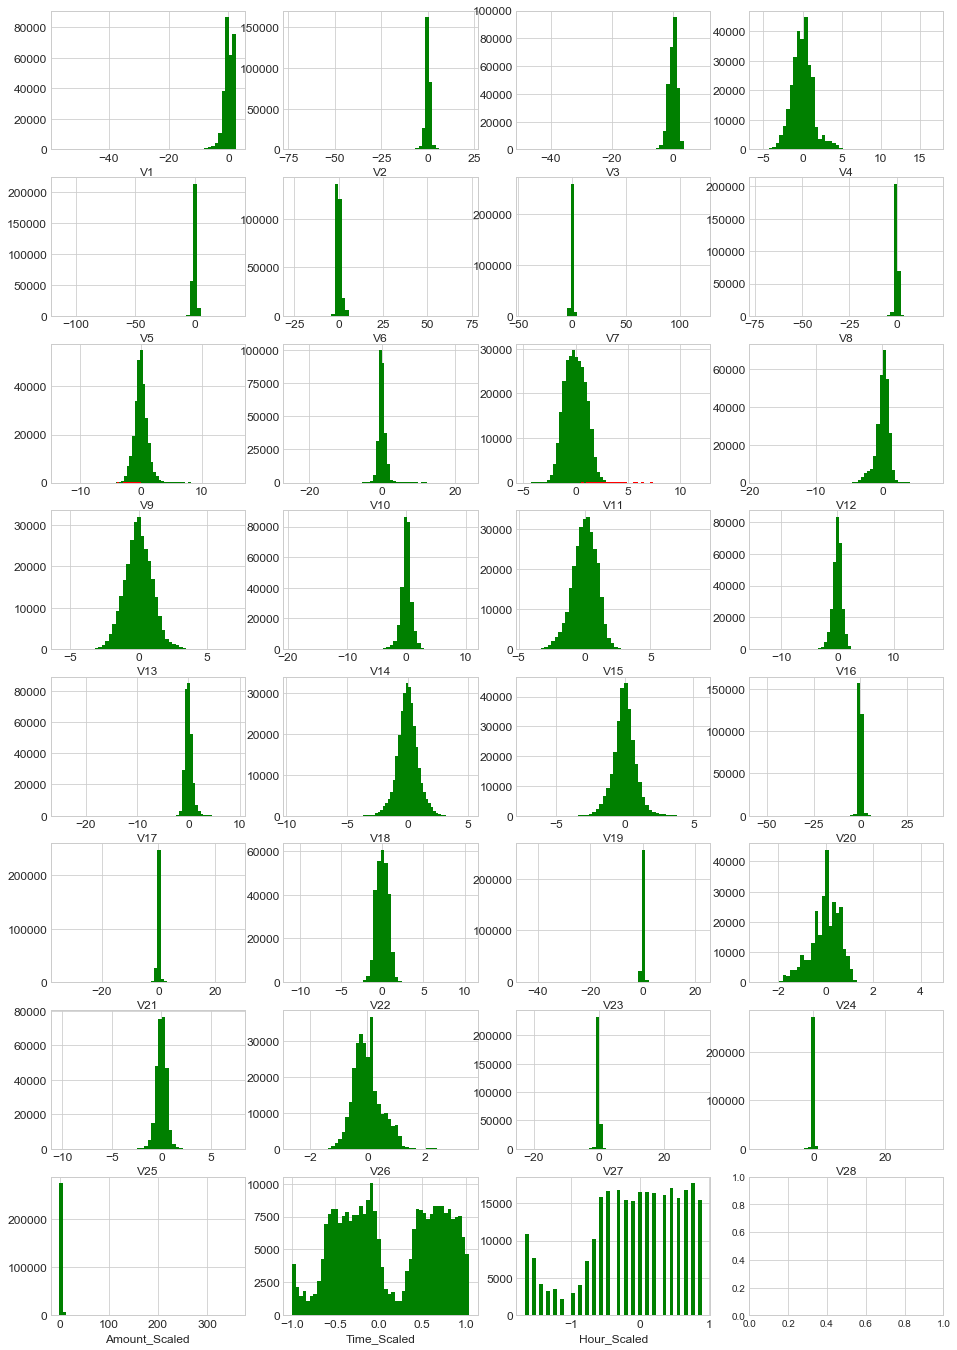

In [135]:
features = [f for f in data.columns if f not in ['Class']]

ii = 1
t0 = data[data['Class'] == 0]
t1 = data[data['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,24))

for feature in features:    
    plt.subplot(8,4,ii)
    t0[feature].hist(bins=50, xlabelsize=8,ylabelsize=8,label="Normal",color="green")
    t1[feature].hist(bins=50, xlabelsize=8,ylabelsize=8,label="Fraudulent", color="red")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    ii += 1
plt.show();

Comment: One cannot see the difference between normal and fraudulent transactions from histograms - have a look into density plots !

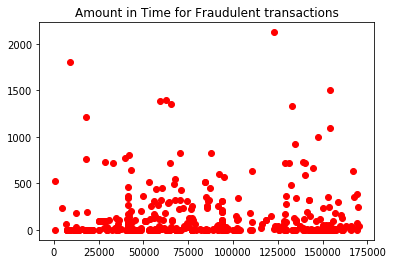

In [14]:
plt.scatter(x='Time',y='Amount',data=data[data.Class==1],color='red');
plt.title("Amount in Time for Fraudulent transactions")
plt.show()

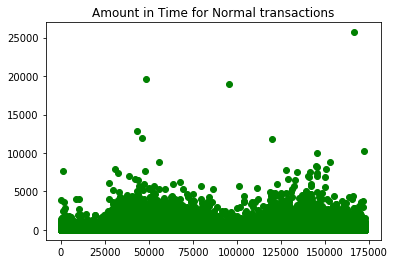

In [15]:
plt.scatter(x='Time',y='Amount',data=data[data.Class==0],color='green');
plt.title("Amount in Time for Normal transactions")
plt.show()

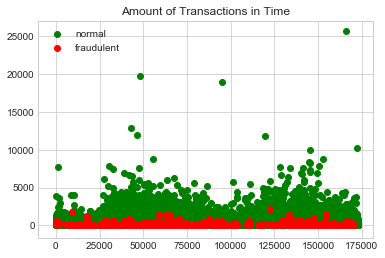

In [143]:

fig, ax = plt.subplots()
for ii in [0,1]:
    n = 750
    color = ['green','red']
    labels = ['normal','fraudulent']
    plt.scatter(x='Time', y='Amount',data=data[data.Class==ii], c=color[ii],label = labels[ii])

plt.title("Amount of Transactions in Time")
ax.legend()
ax.grid(True)

plt.show()

In [17]:
data.groupby('Class').describe()

Amount                                                              \
          count        mean         std  min   25%    50%     75%       max   
Class                                                                         
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16   
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87   

           Time                  ...            V8                   V9  \
          count          mean    ...           75%        max     count   
Class                            ...                                      
0      284315.0  94838.202258    ...      0.326200  18.709255  284315.0   
1         492.0  80746.806911    ...      1.764879  20.007208     492.0   

                                                                              
           mean       std        min       25%       50%      75%        max  
Class                                                                         
0      0.004467  1.089372  -6.290730 -0.640412 -0.049964  0.59823  15.594995  
1     -2.581123  2.500896 -13.434066 -3.872383 -2.208768 -0.78785   3.353525  

[2 rows x 240 columns]

Comment: Mean value of 'Amount' for fraudulent transactions is cca 88, below normal transactions !

### Check Time variable - Create feature Hour

In [144]:
#data.info()

In [19]:
import datetime
def convert_totime(seconds):
    return datetime.datetime.fromtimestamp(seconds);

time_df = data[['Time', 'Amount', 'Class']].copy()
time_df['datetime'] = time_df.Time.apply(convert_totime)

time_df['hour_of_the_day'] = time_df.datetime.dt.hour
time_df_g = time_df.groupby(['Class', 'hour_of_the_day'])['Amount'].count()

In [20]:
time_df_g_sum = time_df.groupby(['Class', 'hour_of_the_day'])['Amount'].sum()

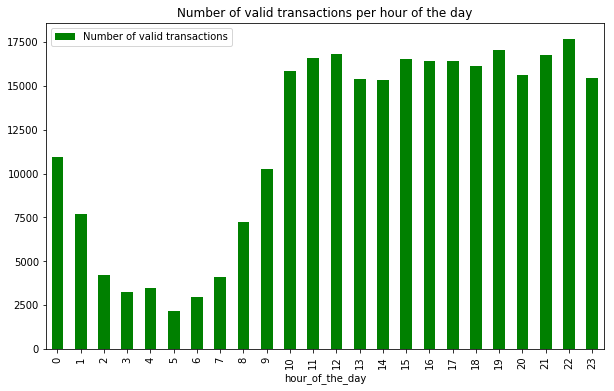

In [21]:
plt.figure(figsize = (10, 6))
valid_tr = time_df_g[0].copy()
valid_tr.name = 'Number of valid transactions'
valid_tr.plot.bar(title = 'Number of valid transactions per hour of the day', legend = True, color='green');

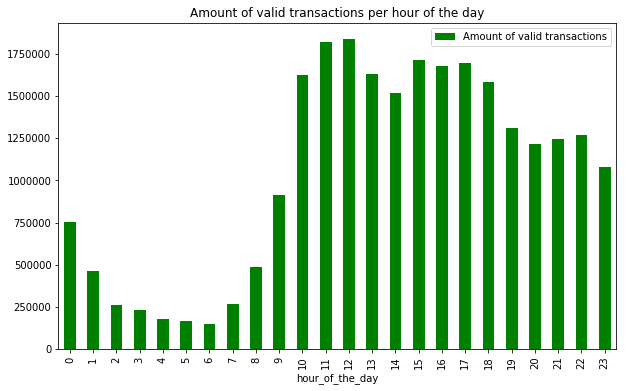

In [22]:
plt.figure(figsize = (10, 6))
valid_tr = time_df_g_sum[0].copy()
valid_tr.name = 'Amount of valid transactions'
valid_tr.plot.bar(title = 'Amount of valid transactions per hour of the day', legend = True, color='green');

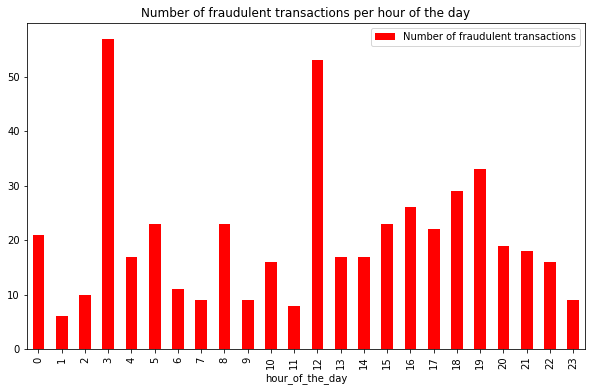

In [23]:
plt.figure(figsize = (10, 6))
fraud_tr = time_df_g[1].copy()
fraud_tr.name = 'Number of fraudulent transactions'
fraud_tr.plot.bar(title = 'Number of fraudulent transactions per hour of the day', legend = True, color ='red');

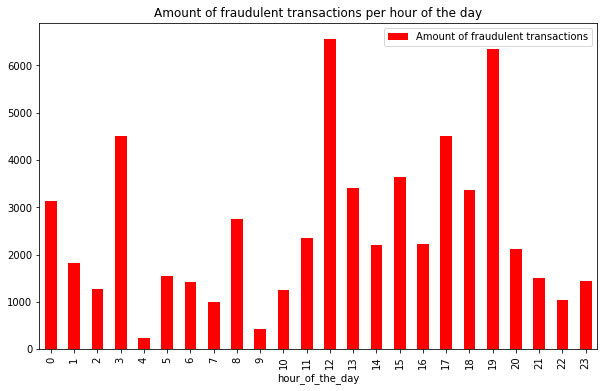

In [24]:
plt.figure(figsize = (10, 6))
fraud_tr = time_df_g_sum[1].copy()
fraud_tr.name = 'Amount of fraudulent transactions'
fraud_tr.plot.bar(title = 'Amount of fraudulent transactions per hour of the day', legend = True, color ='red');

In [25]:
# add feature 'hour_of_the_day' to data

data['datetime'] = data.Time.apply(convert_totime)
data['hour_of_the_day'] = data.datetime.dt.hour


Comment: Number and amount of fraudulent transactions have one peak at 3am, exactly when the number and amount of normal transations are smallest - this is strange for fraud !

## 1. Scaling:  Time and Amount

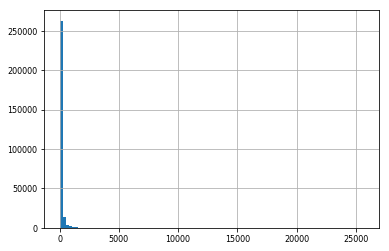

In [26]:
data['Amount'].hist(bins=100, xlabelsize=8, ylabelsize=8); 

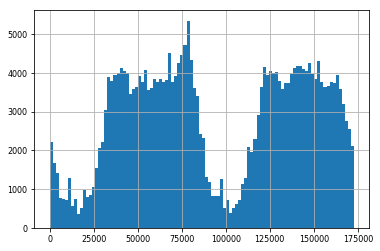

In [27]:
data['Time'].hist(bins=100, xlabelsize=8, ylabelsize=8); 


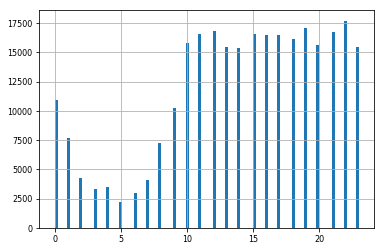

In [28]:
data['hour_of_the_day'].hist(bins=100, xlabelsize=8, ylabelsize=8); 


In [29]:
from sklearn.preprocessing import RobustScaler
    
data['Amount_Scaled'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data['Time_Scaled'] = RobustScaler().fit_transform(data['Time'].values.reshape(-1,1))
data['Hour_Scaled'] = RobustScaler().fit_transform(data['hour_of_the_day'].values.reshape(-1,1))

data.drop(['Time','Amount','hour_of_the_day','datetime'], axis=1, inplace=True)


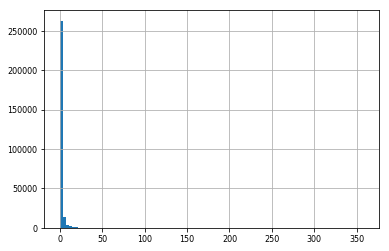

In [30]:
data['Amount_Scaled'].hist(bins=100, xlabelsize=8, ylabelsize=8);

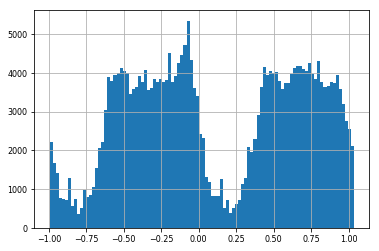

In [31]:
data['Time_Scaled'].hist(bins=100, xlabelsize=8, ylabelsize=8);

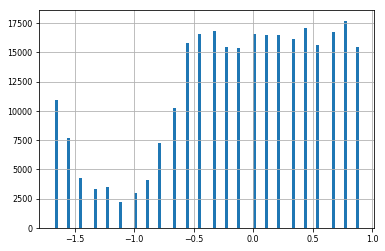

In [32]:
data['Hour_Scaled'].hist(bins=100, xlabelsize=8, ylabelsize=8);

In [33]:
data[['Amount_Scaled','Time_Scaled','Hour_Scaled']].describe()

,Amount_Scaled,Time_Scaled,Hour_Scaled
count,284807.000000,284807.000000,284807.000000
mean,0.927124,0.118914,-0.097250
std,3.495006,0.557903,0.692318
min,-0.307413,-0.994983,-1.666667
25%,-0.229162,-0.358210,-0.555556
50%,0.000000,0.000000,0.000000
75%,0.770838,0.641790,0.444444
max,358.683155,1.035022,0.888889


# Method 1: Downsampling Imbalanced set

In [34]:
df_Fraud = data[data.Class==1]
df_nonFraud = data[data.Class==0]

In [35]:
df_nonFraud_sample = df_nonFraud.sample(n=492, random_state = 11)

In [36]:
# check
df_nonFraud_sample.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Amount_Scaled,Time_Scaled,Hour_Scaled
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0,492.000000,492.000000,492.000000
mean,-0.094855,0.049537,-0.004925,-0.127793,-0.013272,-0.130516,-0.018524,0.004530,-0.032720,0.012718,...,-0.018543,-0.030549,-0.024199,0.006983,-0.010117,-0.015846,0.0,0.849610,0.170240,-0.036360
std,1.938178,1.719855,1.444707,1.358215,1.352004,1.314612,1.273725,1.778025,1.083366,1.058405,...,0.732663,0.600421,0.522307,0.475731,0.426615,0.388916,0.0,2.741056,0.563781,0.673577
min,-14.163808,-13.759429,-9.080561,-3.476829,-6.504598,-8.654663,-14.576443,-33.785407,-3.790132,-5.321055,...,-11.171176,-1.911710,-2.259666,-1.249378,-2.691392,-6.129245,0.0,-0.307413,-0.980286,-1.666667
25%,-1.015179,-0.599566,-0.791444,-0.986450,-0.727583,-0.828437,-0.576730,-0.220000,-0.626541,-0.579976,...,-0.170723,-0.410830,-0.346932,-0.320773,-0.080611,-0.060175,0.0,-0.219975,-0.336047,-0.444444
50%,-0.071979,0.066263,0.098728,-0.178015,-0.067475,-0.330792,0.069303,0.005198,-0.101351,-0.050958,...,-0.028296,-0.007992,-0.018406,-0.061906,0.000533,0.008653,0.0,-0.021170,0.120937,0.111111
75%,1.274977,0.883528,1.001996,0.599028,0.551881,0.314364,0.614480,0.284982,0.521343,0.540571,...,0.144012,0.415144,0.359274,0.260894,0.099231,0.069631,0.0,0.743555,0.691223,0.444444
max,2.360991,8.644034,3.213200,4.792277,11.627491,8.000839,3.659882,8.271724,3.785955,6.534076,...,4.280477,1.620462,1.392677,1.414428,5.417347,3.678780,0.0,29.109621,1.019361,0.888889


In [37]:
df_sample = pd.concat([df_Fraud,df_nonFraud_sample])

In [38]:
# check if 
df_sample.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

## 3. Correlation matrix

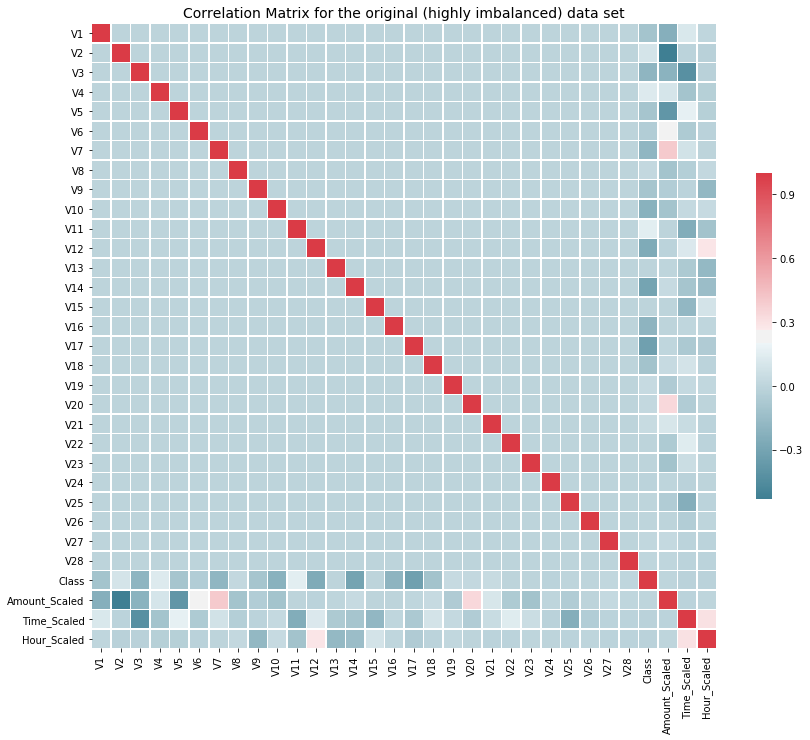

In [39]:
import seaborn as sns

f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = data.corr()
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation Matrix for the original (highly imbalanced) data set", fontsize=14)
plt.show()

Comment: The Features V1-V28 are completely uncorrelated which is expected as they are obtained by perorming PCA on the original dataset.

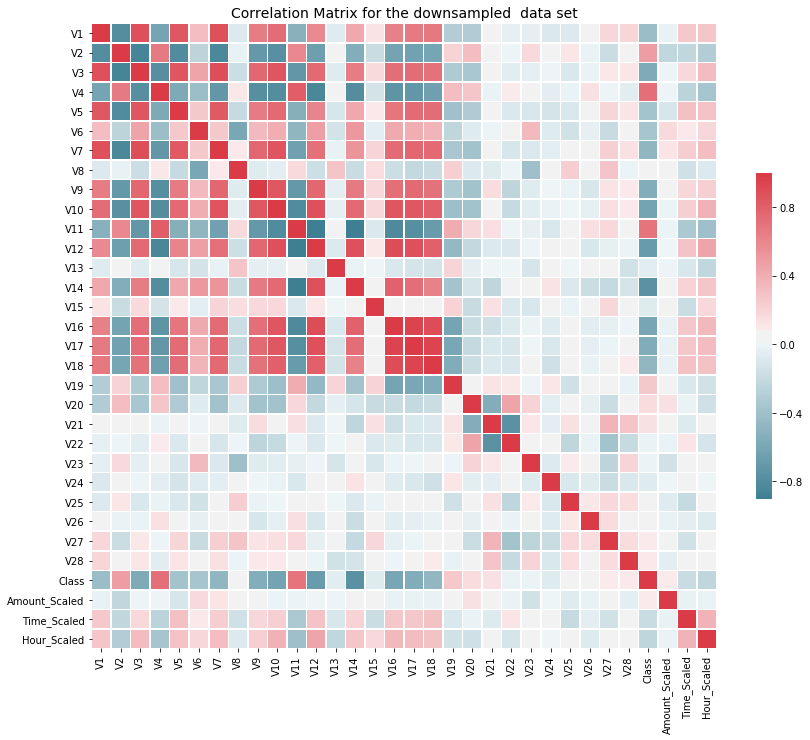

In [40]:

f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df_sample.corr()
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation Matrix for the downsampled  data set", fontsize=14)

plt.show()

Comment:
- Positive correlation with Class: V4, V11, V2, V19 
- Negative correlation with Class: V14, V12, V10, V16, V3, V17, V9, V7, V18, V1, V5, V6

In [41]:
corr['Class'].sort_values()

V14             -0.748102
V12             -0.680834
V10             -0.626489
V16             -0.605523
V3              -0.565464
V17             -0.557788
V9              -0.551912
V7              -0.472967
V18             -0.471418
V1              -0.424799
V5              -0.372132
V6              -0.366634
Hour_Scaled     -0.232739
Time_Scaled     -0.189114
V15             -0.069165
V24             -0.066557
V13             -0.055967
V22             -0.016162
V23             -0.008847
V26              0.047139
V25              0.048698
V8               0.056935
Amount_Scaled    0.086026
V27              0.088388
V28              0.096031
V21              0.131824
V20              0.163687
V19              0.263394
V2               0.480064
V11              0.697011
V4               0.720847
Class            1.000000
Name: Class, dtype: float64

## 4. Check BoxPlots

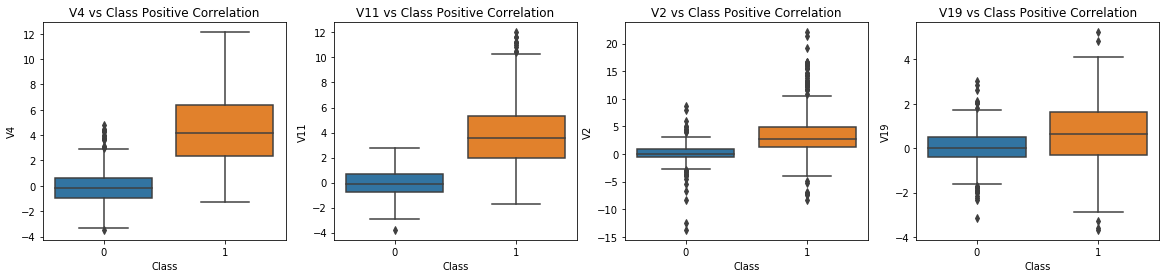

In [42]:
#  Positive correlation with Class: V4, V11, V2, V19

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V4", data=df_sample, ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=df_sample, ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df_sample, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df_sample, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

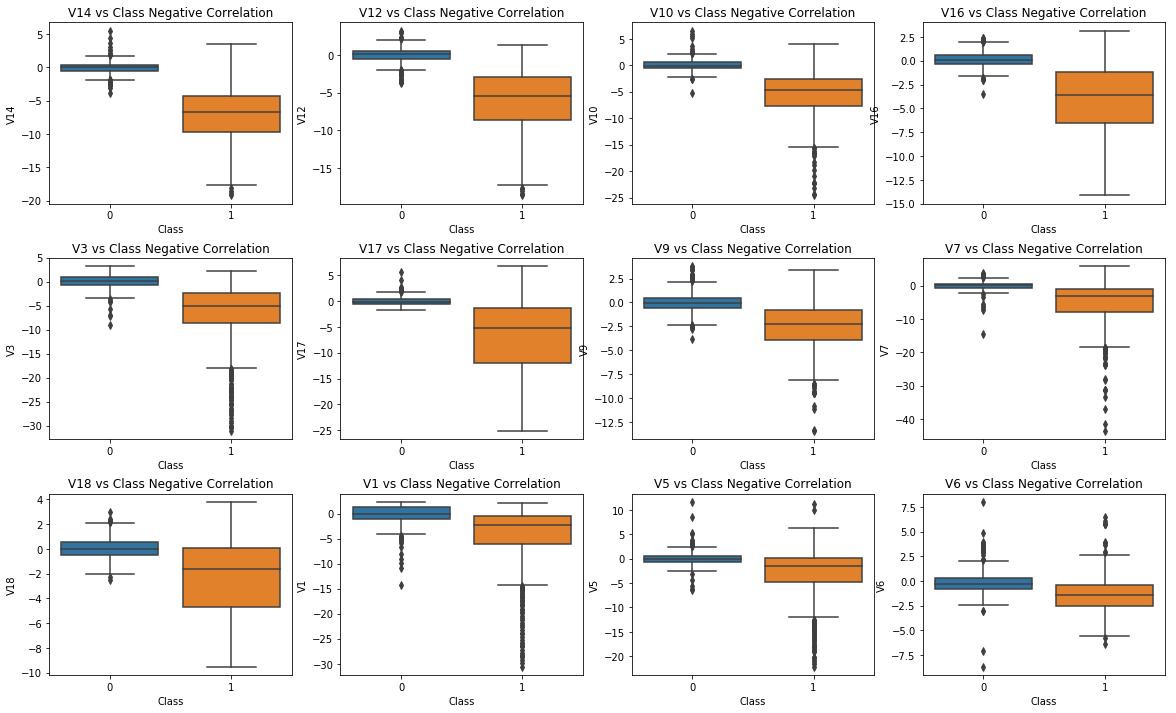

In [43]:
# Negative correlation with Class: V14, V12, V10, V16, V3, V17, V9, V7, V18, V1, V5, V6

f, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))

sns.boxplot(x="Class", y="V14", data=df_sample, ax=axes[0,0])
axes[0,0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=df_sample, ax=axes[0,1])
axes[0,1].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df_sample, ax=axes[0,2])
axes[0,2].set_title('V10 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V16", data=df_sample, ax=axes[0,3])
axes[0,3].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V3", data=df_sample, ax=axes[1,0])
axes[1,0].set_title('V3 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V17", data=df_sample, ax=axes[1,1])
axes[1,1].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V9", data=df_sample, ax=axes[1,2])
axes[1,2].set_title('V9 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V7", data=df_sample, ax=axes[1,3])
axes[1,3].set_title('V7 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V18", data=df_sample, ax=axes[2,0])
axes[2,0].set_title('V18 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V1", data=df_sample, ax=axes[2,1])
axes[2,1].set_title('V1 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V5", data=df_sample, ax=axes[2,2])
axes[2,2].set_title('V5 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V6", data=df_sample, ax=axes[2,3])
axes[2,3].set_title('V6 vs Class Negative Correlation')

plt.subplots_adjust(hspace=0.3)


plt.show()

Comment:
- Positive correlation with Class: V4, V11, V2, V19 -- fraud is more likely to happen for positive values of these features
- Negative correlation with Class: V14, V12, V10, V16, V3, V9, V17, V7, V18, V1, V5, V6 -- fraud is more likely to happen for negative values of these features

- Features - V13, V15, V22, V23, V25 are not very good at differentiating between fraud and valid transactions. So, maybe removing them will lead to a better result.

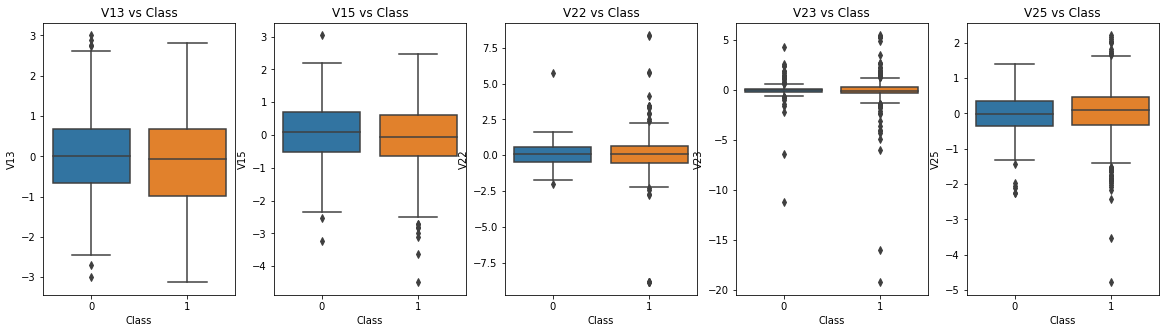

In [44]:
# No correlation: V13, V15, V22, V23, V25

f, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

sns.boxplot(x="Class", y="V13", data=df_sample, ax=axes[0])
axes[0].set_title('V13 vs Class')

sns.boxplot(x="Class", y="V15", data=df_sample, ax=axes[1])
axes[1].set_title('V15 vs Class')


sns.boxplot(x="Class", y="V22", data=df_sample, ax=axes[2])
axes[2].set_title('V22 vs Class')


sns.boxplot(x="Class", y="V23", data=df_sample, ax=axes[3])
axes[3].set_title('V23 vs Class')

sns.boxplot(x="Class", y="V25", data=df_sample, ax=axes[4])
axes[4].set_title('V25 vs Class')

plt.show()

## 5. Modelling 

In [45]:
df_sample = df_sample.sample(frac=1, random_state=11)

In [145]:
#df_sample.info()

## 5.1. Clustering

In [47]:
#from blagging import BlaggingClassifier

In [76]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

# col_drop = ['V13', 'V15', 'V22', 'V23', 'V25']
# X = X.drop(col_drop, axis=1)

X_tsne = TSNE(n_components=2, random_state=11).fit_transform(X.values)
X_pca = PCA(n_components=2, random_state=11).fit_transform(X.values)
X_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=11).fit_transform(X.values)
X_kmeans = KMeans(n_clusters=2, random_state = 11).fit_transform(X.values)


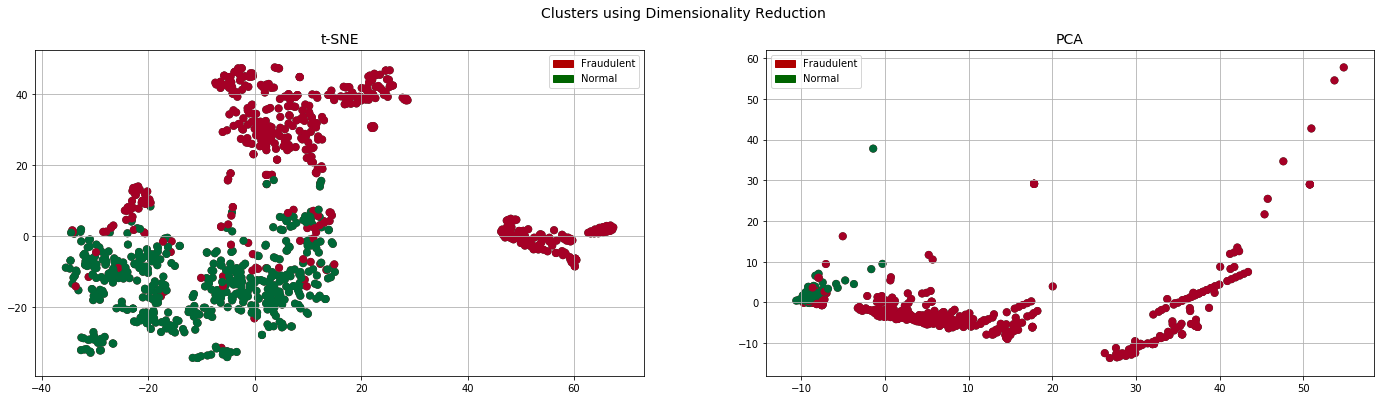

In [77]:
f, ax = plt.subplots(1, 2, figsize=(24,6))

f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

red_patch = mpatches.Patch(color='#AF0000', label='Fraudulent')
green_patch = mpatches.Patch(color='#006400', label='Normal')

# t-SNE scatter plot
ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='RdYlGn', label='Fraudulent', linewidths=2)
ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='RdYlGn', label='Normal', linewidths=2)
ax[0].set_title('t-SNE', fontsize=14)

ax[0].grid(True)
ax[0].legend(handles=[red_patch, green_patch])


# PCA scatter plot
ax[1].scatter(X_pca[:,0], X_pca[:,1], c=(y == 1), cmap='RdYlGn', label='Fraudulent', linewidths=2)
ax[1].scatter(X_pca[:,0], X_pca[:,1], c=(y == 0), cmap='RdYlGn', label='Normal', linewidths=2)
ax[1].set_title('PCA', fontsize=14)

ax[1].grid(True)
ax[1].legend(handles=[red_patch, green_patch])


plt.show()


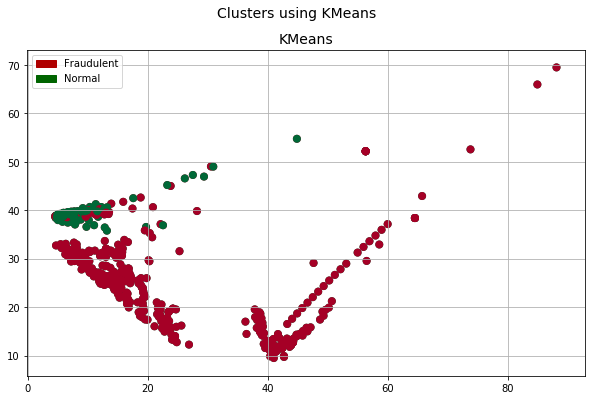

In [79]:
ff, axx = plt.subplots(1, 1, figsize=(10,6))

ff.suptitle('Clusters using KMeans', fontsize=14)

red_patch = mpatches.Patch(color='#AF0000', label='Fraudulent')
green_patch = mpatches.Patch(color='#006400', label='Normal')

# KMeans scatter plot
axx.scatter(X_kmeans[:,0], X_kmeans[:,1], c=(y == 1), cmap='RdYlGn', label='Fraudulent', linewidths=2)
axx.scatter(X_kmeans[:,0], X_kmeans[:,1], c=(y == 0), cmap='RdYlGn', label='Normal', linewidths=2)
axx.set_title('KMeans', fontsize=14)

axx.grid(True)
axx.legend(handles=[red_patch, green_patch])

plt.show()


### Accuracy score for KMeans

In [80]:
# Check accuracy of KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score


X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

kmeans = KMeans(n_clusters=2, random_state=11)
clusters = kmeans.fit_predict(X.values)

labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y.values[mask])[0]

print("Accuracy score for KMeans: ", round(accuracy_score(y.values, labels)*100,2),"%")


Accuracy score for KMeans:  66.26 %


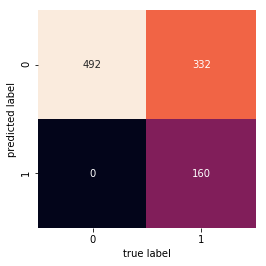

In [81]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y.values, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)#,xticklabels=y.target_names,  yticklabels=y.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');


Just for fun, let's try to push this even farther. We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in In-Depth: Manifold Learning) to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

### Accuracy score for KMeans with preprocessing t-SNE and PCA

In [82]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=11)
X_proj = tsne.fit_transform(X.values)
# Compute the clusters
kmeans = KMeans(n_clusters=2, random_state=11)
clusters = kmeans.fit_predict(X_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y.values[mask])[0]

# Compute the accuracy
print("Accuracy score for KMeans with t-SNE preprocessing: ", round(accuracy_score(y.values, labels)*100,2),"%")


Accuracy score for KMeans with t-SNE preprocessing:  88.92 %


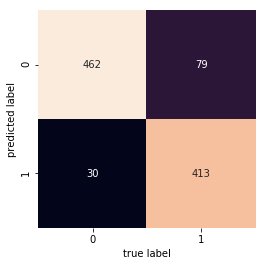

In [83]:
mat = confusion_matrix(y.values, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)#,xticklabels=y.target_names,  yticklabels=y.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');


In [84]:
pca = PCA(n_components=2, random_state=11)
X_proj = pca.fit_transform(X.values)
# Compute the clusters
kmeans = KMeans(n_clusters=2, random_state=11)
clusters = kmeans.fit_predict(X_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y.values[mask])[0]

# Compute the accuracy
print("Accuracy score for KMeans with PCA preprocessing: ", round(accuracy_score(y.values, labels)*100,2),"%")


Accuracy score for KMeans with PCA preprocessing:  66.16 %


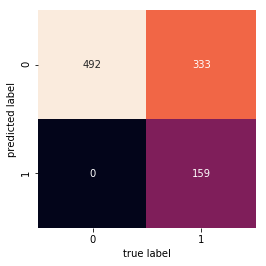

In [85]:
mat = confusion_matrix(y.values, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)#,xticklabels=y.target_names,  yticklabels=y.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Comment: KMeans with t-SNE preprocessing gives 88.92% accuracy while with PCA preprocessing is less then accuracy of KMeans only !

## 5.2 Classifiers

In [86]:
# turn off warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}

In [88]:
# Check accuracy scores for cross validation
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring ='accuracy')
    print("Classifier: ", classifier.__class__.__name__, "has Accuracy score of", round(training_score.mean(), 2) * 100)

Classifier:  LogisticRegression has Accuracy score of 94.0
Classifier:  KNeighborsClassifier has Accuracy score of 93.0
Classifier:  SVC has Accuracy score of 93.0
Classifier:  DecisionTreeClassifier has Accuracy score of 91.0
Classifier:  RandomForestClassifier has Accuracy score of 93.0
Classifier:  GradientBoostingClassifier has Accuracy score of 93.0


In [89]:
# Use GridSearchCV to find the best parameters
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
lr_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_lr = GridSearchCV(LogisticRegression(), lr_params)
grid_lr.fit(X_train, y_train)
lr = grid_lr.best_estimator_
lr_pred = lr.predict(X_test)


# KNearest heighbours
knn_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_train, y_train)
knn = grid_knn.best_estimator_
knn_pred = knn.predict(X_test)

# Support Vector Machines
svm_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svm = GridSearchCV(SVC(), svm_params)
grid_svm.fit(X_train, y_train)
svm = grid_svm.best_estimator_
svm_pred = svm.predict(X_test)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree = grid_tree.best_estimator_
tree_pred = tree.predict(X_test)


In [90]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators = 100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

In [91]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_threshold = roc_curve(y_test, lr_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knn_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svm_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_pred)

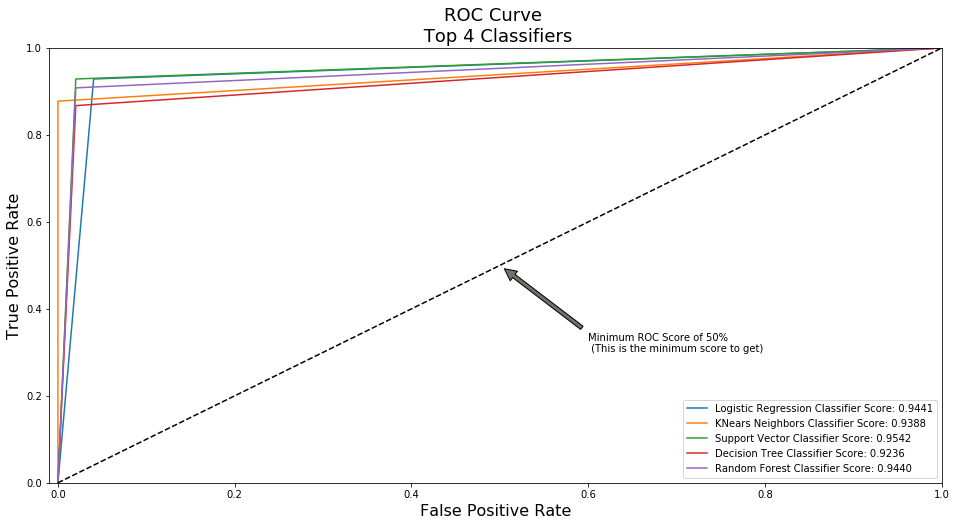

In [92]:
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rf_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, lr_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_test, knn_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, svm_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_test, tree_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test, rf_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rf_tpr)
plt.show()


In [93]:
print("Classification report: Logistic Regression")
print(classification_report(y_test,lr_pred))
#
print("Classification report: Knearest neighbours")
print(classification_report(y_test,knn_pred))
#
print("Classification report: Support Vector Classifier")
print(classification_report(y_test,svm_pred))
#
print("Classification report: Decision Tree Classifier")
print(classification_report(y_test,tree_pred))
#
print("Classification report: Random Forest Classifier")
print(classification_report(y_test,rf_pred))



Classification report: Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.96      0.93      0.94        98

   micro avg       0.94      0.94      0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

Classification report: Knearest neighbours
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        99
           1       1.00      0.88      0.93        98

   micro avg       0.94      0.94      0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197

Classification report: Support Vector Classifier
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        99
           1       0.98      0.93      0.95        98

   micro avg       0.95      0.95      0.95    

In [94]:
print("ROC AUC for Logistic Regression: ", roc_auc_score(y_test,lr_pred))
#
print("ROC AUC for Knearest neighbours: ", roc_auc_score(y_test,knn_pred))
#
print("ROC AUC for Support Vector Classifier: ", roc_auc_score(y_test,svm_pred))
#
print("ROC AUC for Decision Tree Classifier: ", roc_auc_score(y_test,tree_pred))
#
print("ROC AUC for Random Forest Classifier: ", roc_auc_score(y_test,rf_pred))



ROC AUC for Logistic Regression:  0.9440836940836941
ROC AUC for Knearest neighbours:  0.9387755102040816
ROC AUC for Support Vector Classifier:  0.9541847041847041
ROC AUC for Decision Tree Classifier:  0.9235724592867449
ROC AUC for Random Forest Classifier:  0.9439806225520511


In [86]:
## Feature Importance

In [95]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('Class', axis=1)
# col_drop = ['V13', 'V15', 'V22', 'V23', 'V25']
# X = X.drop(col_drop, axis=1)
y = df_sample['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Turn the values into an array for feeding the classification algorithms.
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [96]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
featureimp = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print (featureimp)

V14              0.144263
V4               0.133690
V10              0.117814
V12              0.116895
V17              0.080144
V11              0.078614
V16              0.045687
V3               0.042861
V2               0.029392
V21              0.023989
V7               0.017210
V18              0.014085
V19              0.013188
V6               0.012236
V8               0.011975
Amount_Scaled    0.011196
V9               0.010836
V1               0.010326
V5               0.010170
V26              0.009677
V20              0.009272
V25              0.007136
V28              0.006600
V13              0.006543
V27              0.006189
V15              0.005849
V22              0.005520
Time_Scaled      0.005465
V23              0.005281
V24              0.003985
Hour_Scaled      0.003910
dtype: float64


Terms:
- True Positives: Correctly Classified Fraudulent Transactions 
- False Positives: Incorrectly Classified Fraudulent Transactions
- True Negative: Correctly Classified Normal Transactions
- False Negative: Incorrectly Classified Normal Transactions
- Precision: True Positives/(True Positives + False Positives)
- Recall: True Positives/(True Positives + False Negatives) <br>
<br>
Precision = how precise is our model in detecting fraudulent transactions <br>
Recall = amount of fraudulent cases our model is able to detect. <br>
Precision/Recall Tradeoff: The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect.

# Blagging Classifier

In [97]:
#from blagging import BlaggingClassifier


# Method 2: OVERSAMPLING

In [98]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

In [99]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
V1               284807 non-null float64
V2               284807 non-null float64
V3               284807 non-null float64
V4               284807 non-null float64
V5               284807 non-null float64
V6               284807 non-null float64
V7               284807 non-null float64
V8               284807 non-null float64
V9               284807 non-null float64
V10              284807 non-null float64
V11              284807 non-null float64
V12              284807 non-null float64
V13              284807 non-null float64
V14              284807 non-null float64
V15              284807 non-null float64
V16              284807 non-null float64
V17              284807 non-null float64
V18              284807 non-null float64
V19              284807 non-null float64
V20              284807 non-null float64
V21              284807 non-null float64
V22              284807 non-

In [102]:
X = data.drop('Class',axis=1)
y = data['Class']

In [103]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [104]:
original_Xtrain = X_train.values
original_Xtest = X_test.values
original_ytrain = y_train.values
original_ytest = y_test.values

In [105]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [121]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))


# Logistic Regression
lr_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_lr = RandomizedSearchCV(LogisticRegression(), lr_params)

# Support Vector Machines
svm_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svm = GridSearchCV(SVC(), svm_params)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)

# Random Forest
rf_params ={'n_estimators':[10,20]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)

#----------------------------------------
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

#----------------------------------------
def predict_(grid_model):
    for train, test in sss.split(original_Xtrain, original_ytrain):
        pipeline = imbalanced_make_pipeline(SMOTE(), grid_model) # SMOTE happens during Cross Validation
        model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
        best_est = grid_model.best_estimator_
        prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
    print('---' * 20)
    print('')
    print("Accuracy: {}".format(np.mean(accuracy_lst)))
    print("Precision: {}".format(np.mean(precision_lst)))
    print("Recall: {}".format(np.mean(recall_lst)))
    print("F1 score: {}".format(np.mean(f1_lst)))
    print('---' * 20)
    labels = ['Normal', 'Fraudulent']
    smote_prediction = best_est.predict(original_Xtest)
    print(classification_report(original_ytest, smote_prediction, target_names=labels))


Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962


In [123]:
predict_(grid_rf)

------------------------------------------------------------

Accuracy: 0.9993855471921701
Precision: 0.8311688311688312
Recall: 0.810126582278481
F1 score: 0.8205128205128205
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
  Fraudulent       0.92      0.82      0.86        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [124]:
predict_(grid_lr)

------------------------------------------------------------

Accuracy: 0.9874585792973294
Precision: 0.44497112767981595
Recall: 0.8417721518987342
F1 score: 0.46532424744715245
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     56864
  Fraudulent       0.06      0.93      0.11        98

   micro avg       0.97      0.97      0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

